In [1]:
import datetime
from collections import defaultdict
import warnings
from scipy.optimize import minimize
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import ModelCheckpoint
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import Quote
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from stock_indicators.indicators.common.enums import PeriodSize
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import GARCH

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080 SUPER'

In [2]:
funds_w_names = defaultdict(pd.DataFrame)

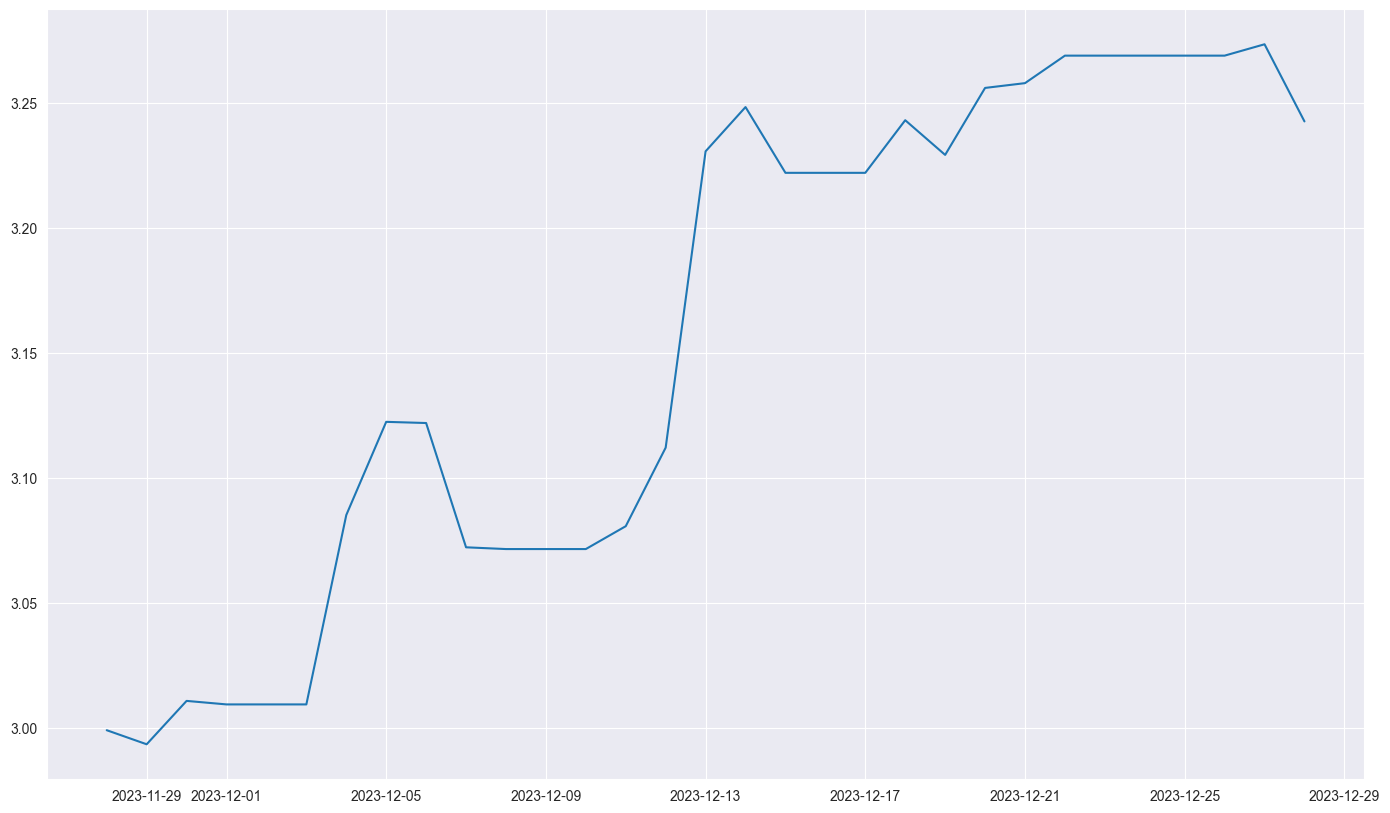

In [14]:
fig = plt.figure(figsize=(17, 10))
plt.plot(funds_w_names["DTLE.L"]["Close"][-31:])

In [3]:
etf_names = ["IE00BFNM3G45", "IE00BHZPJ783", "36BA.DE", "DTLE.L", "UEEF.DE"]
# ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B5M4WH52','IE00B66F4759','EMBE.L', 'DTLE.L','IE00BDFK1573','IBC5.DE','IE00BFNM3G45','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
#  'IE00BLDGH553','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44','ISVIF', "IESE.AS", "UEEF.DE"]


In [4]:
for fund in etf_names:
    print(fund)
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2020-12-01", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    a.index = a.index.normalize()
    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)

    print(len(a))

    a["Return"] = np.log(1+a["Close"].pct_change())
    a["Rolling Volatility"] = a["Return"].rolling(7).std()

    a.fillna(method="bfill", inplace=True)
    if fund != 'ISVIF':
        a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    else:
        a.drop(["Dividends", "Stock Splits"], inplace=True, axis=1)
    a.index = pd.to_datetime(a.index, utc=True)
    if a.index.hour[0] == 0:
        a.index = a.index + datetime.timedelta(hours=-1)
    a.index = a.index.normalize()

    a = a.sort_index()

    a["time_idx"] = (a.index - a.index.min()).days
    a["group_id"] = fund
    funds_w_names[fund] = a

IE00BFNM3G45
1124
IE00BHZPJ783
1124
36BA.DE
1124
DTLE.L
1124
UEEF.DE
1124


In [5]:
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):
        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in f.itertuples()]


        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)


        rsi_for_f = sa.indicators.get_rsi(quotes=quotes_for_f)
        valid_rsi_for_f = [
            (result.date, result.rsi)
            for result in rsi_for_f
            if result.date is not None and result.rsi is not None
        ]
        rsi_dates, rsi_values = zip(*valid_rsi_for_f)


        bb_for_f = sa.indicators.get_bollinger_bands(quotes=quotes_for_f)
        valid_bb_for_f = [
            (result.date, result.lower_band, result.upper_band)
            for result in bb_for_f
            if result.date is not None and result.lower_band is not None
        ]
        bb_dates, bb_lower, bb_upper = zip(*valid_bb_for_f)


        vwap_for_f = sa.indicators.get_vwap(quotes=quotes_for_f)
        valid_vwap_for_f = [
            (result.date, result.vwap)
            for result in vwap_for_f
            if result.date is not None and result.vwap is not None
        ]
        vwap_dates, vwap_values = zip(*valid_vwap_for_f)



        pp_for_f = sa.indicators.get_pivot_points(quotes=quotes_for_f, window_size=PeriodSize.DAY)
        valid_pp_for_f = [
            (result.date, result.pp, result.r1, result.r2, result.r3, result.r4, result.s1, result.s2, result.s3, result.s4)
            for result in pp_for_f
            if result.date is not None and result.pp is not None
        ]
        pp_dates, pp, r1, r2, r3, r4, s1, s2, s3, s4 = zip(*valid_pp_for_f)

        fig, axes = plt.subplots(5, 1, figsize=(12,12))


        axes[0].plot(macd_dates[-20:], macd_values[-20:], label='MACD_values', linewidth=2)
        axes[0].plot(macd_dates[-20:], macd_signal[-20:], label='MACD_signal', linewidth=2)
        axes[0].legend(loc='best')

        axes[1].plot(rsi_dates[-20:], rsi_values[-20:], label='RSI', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(bb_dates[-20:], bb_lower[-20:], label='BB_lower', linewidth=2)
        axes[2].plot(bb_dates[-20:], bb_upper[-20:], label='BB_upper', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(vwap_dates[-20:], vwap_values[-20:], label='vwap', linewidth=2)
        axes[3].legend(loc='best')

        axes[4].plot(pp_dates[-20:], pp[-20:], label='pivot points', linewidth=2)
        axes[4].plot(pp_dates[-20:], r1[-20:], label='r1', linewidth=2)
        axes[4].plot(pp_dates[-20:], r4[-20:], label='r4', linewidth=2)
        axes[4].plot(pp_dates[-20:], s1[-20:], label='s1', linewidth=2)
        axes[4].plot(pp_dates[-20:], s4[-20:], label='s4', linewidth=2)
        axes[4].legend(loc='best')


        figs.append(fig)

        f['Bullish'] = [1 if x.histogram and x.histogram > 0 else 0 for x in macd_for_f]
        f['Bearish'] = [1 if x.histogram and x.histogram < 0 else 0 for x in macd_for_f]
        f['isOverbought'] = [1 if x.rsi and x.rsi > 70 else 0 for x in rsi_for_f ]
        f['isOversold'] = [1 if x.rsi and x.rsi < 30 else 0 for x in rsi_for_f ]


        f.fillna(method="ffill", inplace=True)
        indicators_per_fund[names[id]]= f
    return indicators_per_fund

In [6]:
def optuna(batch_size: int, df: pd.DataFrame, independent_variables: list, target="Close", training_cutoff_idx: pd.Timestamp=598, max_prediction_length=61, min_encoder_length=22):
    tablica_z_optymalnymi = []
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",  # Sequential time index
        target=target,  # Target variable
        group_ids=["group_id"],  # Group identifier
        min_encoder_length=min_encoder_length,  # Minimum input sequence length
        max_encoder_length=334,  # Maximum input sequence length
        min_prediction_length=1,  # Minimum forecast length
        max_prediction_length=max_prediction_length,  # Maximum forecast length (31 for December)
        static_categoricals=["group_id"],
        static_reals=[],  # No static real variables
        time_varying_known_reals=independent_variables,  # Known inputs
        time_varying_unknown_reals=[target],  # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,  # Add relative time index
        add_target_scales=True,  # Scale the target variable
        add_encoder_length=True,  # Include encoder length feature
        allow_missing_timesteps=False,  # Ensure no missing steps

    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True  # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=400,
        max_epochs=150,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(64, 256),
        hidden_continuous_size_range=(64, 256),
        attention_head_size_range=(2, 8),
        learning_rate_range=(0.001, 0.01),
        dropout_range=(0.05, 0.2),
        trainer_kwargs=dict(limit_train_batches=30),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    )

    tablica_z_optymalnymi.append(study.best_trial.params)
    return tablica_z_optymalnymi

In [14]:
def fit(gradient_clip, drop, hidden_size, hidden_continuous_size, attention_head_size, learning_rate, epochs: int, batch_size: int, df: pd.DataFrame, independent_variables: list, target="Close", training_cutoff_idx=875, max_prediction_length=61, min_encoder_length=22):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",  # Sequential time index
        target=target,  # Target variable
        group_ids=["group_id"],  # Group identifier
        min_encoder_length=min_encoder_length,  # Minimum input sequence length
        max_encoder_length=334,  # Maximum input sequence length
        min_prediction_length=1,  # Minimum forecast length
        max_prediction_length=max_prediction_length,  # Maximum forecast length (31 for December)
        static_categoricals=["group_id"],
        static_reals=[],  # No static real variables
        time_varying_known_reals=independent_variables,  # Known inputs
        time_varying_unknown_reals=[target],  # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,  # Add relative time index
        add_target_scales=True,  # Scale the target variable
        add_encoder_length=True,  # Include encoder length feature
        allow_missing_timesteps=False,  # Ensure no missing steps

    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True  # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,  # Learning rate
        hidden_size=hidden_size,  # Model hidden size
        attention_head_size=attention_head_size,  # Number of attention heads
        dropout=drop,  # Dropout rate
        hidden_continuous_size=hidden_continuous_size,  # Hidden size for continuous variables
        output_size=7,  # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),  # Loss function
        log_interval=10,  # Log every 10 batches
        reduce_on_plateau_patience=4,  # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=8, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cpu',
        devices="auto",
        gradient_clip_val=gradient_clip,
        callbacks=[early_stop_callback, lr_logger],  #, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    return tft, training, val_dataloader

In [8]:
def predictt(tft, training, data):
    pred_data = TimeSeriesDataSet.from_dataset(
        dataset=training,
        data=data,
        predict=True,
        stop_randomization=True)

    pred_dataloader = pred_data.to_dataloader(train=False, batch_size=64 * 10, num_workers=0)

    raw_predictions = tft.predict(pred_dataloader, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [9]:
def huber_loss(actual_val, pred_val, delta=5.0):
    err = np.abs(actual_val - pred_val)
    return np.mean(np.where( err <= delta, 0.5 * err**2, delta * (err - 0.5 * delta)))

In [10]:
from decimal import Decimal
def relative_squared_error(true, pred):
    true = np.array([Decimal(float(x)) for x in true])
    pred = np.array([Decimal(float(x)) for x in pred])

    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

def relative_absolute_error(true, pred):
    true = np.array([Decimal(float(x)) for x in true])
    pred = np.array([Decimal(float(x)) for x in pred])
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.abs(true - pred))
    squared_error_den = np.sum(np.abs(true - true_mean))
    rae_loss = squared_error_num / squared_error_den
    return rae_loss

In [11]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range, target="Close", date = "2023-12-01"):
    print(len(df))
    print(len(preds))
    actual_values = df[target][date:]
    rse = relative_squared_error(actual_values, preds)
    rae = relative_absolute_error(actual_values, preds)
    huber = huber_loss(actual_values, preds)
    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label=f"Actual {target}", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for November 30th up to December 29th, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return rse, rae, huber

BASELINE MODEL

In [348]:
f1 = funds_w_names['DTLE.L']["Close"][:-30]

In [349]:
model = ARIMA(f1, order=(5, 2, 0))
model_fit = model.fit()
arima_forecast = model_fit.forecast(steps=30)
print("ARIMA Forecast for the next 30 periods:", arima_forecast)

ARIMA Forecast for the next 30 periods: 2023-11-29 00:00:00+00:00   3.010175
2023-11-30 00:00:00+00:00   3.023252
2023-12-01 00:00:00+00:00   3.035149
2023-12-02 00:00:00+00:00   3.050559
2023-12-03 00:00:00+00:00   3.068084
2023-12-04 00:00:00+00:00   3.083588
2023-12-05 00:00:00+00:00   3.097811
2023-12-06 00:00:00+00:00   3.112299
2023-12-07 00:00:00+00:00   3.127163
2023-12-08 00:00:00+00:00   3.142591
2023-12-09 00:00:00+00:00   3.157899
2023-12-10 00:00:00+00:00   3.172842
2023-12-11 00:00:00+00:00   3.187722
2023-12-12 00:00:00+00:00   3.202700
2023-12-13 00:00:00+00:00   3.217781
2023-12-14 00:00:00+00:00   3.232888
2023-12-15 00:00:00+00:00   3.247930
2023-12-16 00:00:00+00:00   3.262934
2023-12-17 00:00:00+00:00   3.277949
2023-12-18 00:00:00+00:00   3.292988
2023-12-19 00:00:00+00:00   3.308038
2023-12-20 00:00:00+00:00   3.323080
2023-12-21 00:00:00+00:00   3.338111
2023-12-22 00:00:00+00:00   3.353141
2023-12-23 00:00:00+00:00   3.368176
2023-12-24 00:00:00+00:00   3.38321

In [350]:
arima_rse = relative_squared_error(funds_w_names["DTLE.L"]["Close"][-30:], arima_forecast)
arima_rae = relative_absolute_error(funds_w_names["DTLE.L"]["Close"][-30:], arima_forecast)

In [351]:
arima_rse

Decimal('0.6980116999345302695066451528')

In [352]:
sf = StatsForecast(models=[GARCH()], freq='D')
f1=pd.DataFrame(f1)
f1['ds'] = pd.to_datetime(f1.index)
f1.rename(columns={'Close': 'y'}, inplace=True)
f1['unique_id']=1

In [353]:
garch_forecast = sf.forecast(h=30, df=f1)

print(garch_forecast)

    unique_id                        ds  GARCH(1,1)
0           1 2023-11-29 00:00:00+00:00    1.120415
1           1 2023-11-30 00:00:00+00:00   -0.409645
2           1 2023-12-01 00:00:00+00:00   -0.352154
3           1 2023-12-02 00:00:00+00:00   -0.715268
4           1 2023-12-03 00:00:00+00:00    0.577792
5           1 2023-12-04 00:00:00+00:00   -1.535545
6           1 2023-12-05 00:00:00+00:00    1.173433
7           1 2023-12-06 00:00:00+00:00   -0.509964
8           1 2023-12-07 00:00:00+00:00    0.212795
9           1 2023-12-08 00:00:00+00:00   -0.166185
10          1 2023-12-09 00:00:00+00:00    0.974304
11          1 2023-12-10 00:00:00+00:00   -1.377846
12          1 2023-12-11 00:00:00+00:00   -0.216444
13          1 2023-12-12 00:00:00+00:00   -0.255942
14          1 2023-12-13 00:00:00+00:00    0.755624
15          1 2023-12-14 00:00:00+00:00   -0.734519
16          1 2023-12-15 00:00:00+00:00   -0.115135
17          1 2023-12-16 00:00:00+00:00   -0.584945
18          

In [363]:
garch_mse = mean_squared_error(funds_w_names["DTLE.L"]["Rolling Volatility"][-30:], garch_forecast["GARCH(1,1)"])
print(garch_mse)
sample_variance = np.var(garch_forecast["GARCH(1,1)"], ddof=1)
print(f"Sample Variance: {sample_variance}")

n = len(garch_forecast["GARCH(1,1)"])
half_n = n // 2

std_n = np.std(garch_forecast["GARCH(1,1)"])
std_half_n = np.std(garch_forecast["GARCH(1,1)"][:half_n])

convergence_factor = std_half_n / std_n
print(f"Convergence Factor: {convergence_factor}")

0.4597164275614657
Sample Variance: 0.4728201308395737
Convergence Factor: 1.2050925402879975


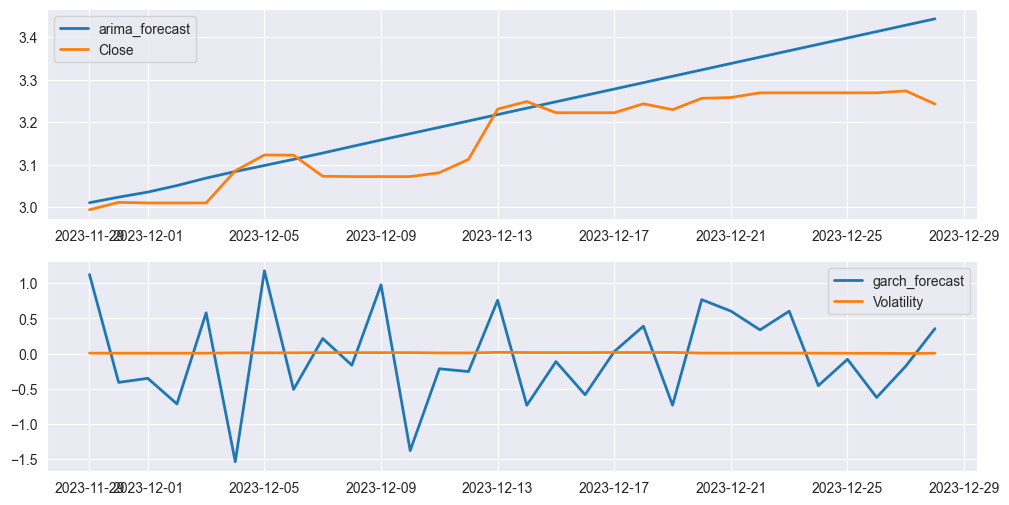

In [355]:
fig, axes = plt.subplots(2, 1, figsize=(12,6))


axes[0].plot(funds_w_names["DTLE.L"][-30:].index, arima_forecast[-30:], label='arima_forecast', linewidth=2)
axes[0].plot(funds_w_names["DTLE.L"][-30:].index, funds_w_names["DTLE.L"]["Close"][-30:], label='Close', linewidth=2)
axes[0].legend(loc='best')
axes[1].plot(funds_w_names["DTLE.L"][-30:].index, garch_forecast["GARCH(1,1)"], label='garch_forecast', linewidth=2)
axes[1].plot(funds_w_names["DTLE.L"][-30:].index, funds_w_names["DTLE.L"]["Rolling Volatility"][-30:], label='Volatility', linewidth=2)
axes[1].legend(loc='best')
plt.legend()
plt.show()

data split

In [12]:
test_funds = defaultdict(pd.DataFrame)
train_funds = defaultdict(pd.DataFrame)
for i in funds_w_names:
    test_funds[i] = funds_w_names[i][-31:]
    train_funds[i] = funds_w_names[i][:-31]
    #test_funds[i]= test_funds[i].drop('Close', axis=1)
    test_funds[i]["Close"] = 0.0
    test_funds[i].index = pd.to_datetime(test_funds[i].index)
    
    train_funds[i].index = pd.to_datetime(train_funds[i].index)
    test_funds[i]["time_idx"] = (test_funds[i].index - test_funds[i].index.min()).days
    train_funds[i]["time_idx"] = (train_funds[i].index - train_funds[i].index.min()).days

1) ONE FUND, NO INDICATORS, PRICE

In [15]:
IE_tft_noind, training_noind, val_noind = fit(epochs=100, batch_size=128, df=train_funds['DTLE.L'], independent_variables=["Open", "High", "Low", "Volume"], drop=0.14, hidden_size=31, learning_rate=0.006, attention_head_size=4, gradient_clip=0.4, hidden_continuous_size=9, max_prediction_length=31, min_encoder_length=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 162    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.5 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.0 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.0 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
IE_preds_noind = predictt(IE_tft_noind, training_noind, test_funds["DTLE.L"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


1124
31


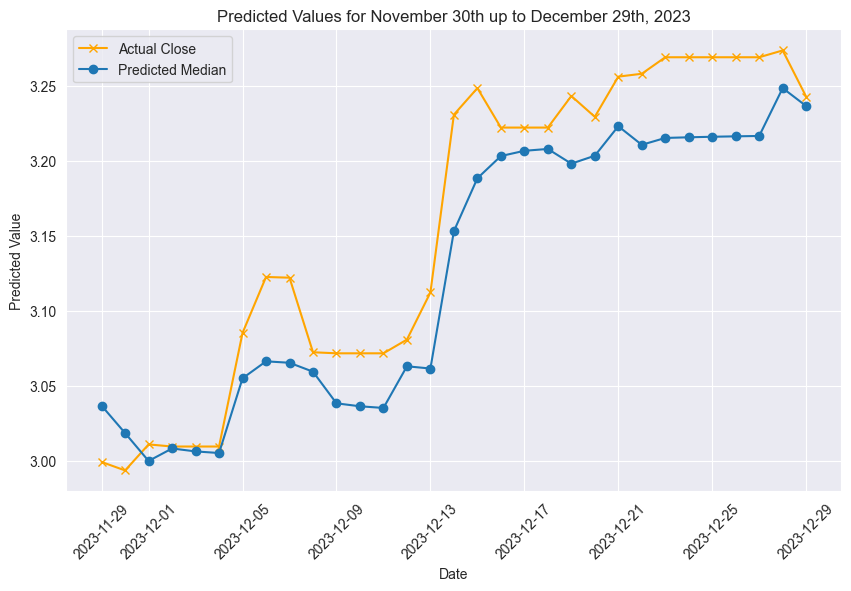

In [17]:
IE_rse_noind, IE_rae_noind, IE_huber_noind= metrics_and_plt(funds_w_names['DTLE.L'], IE_preds_noind[-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [18]:
print(IE_rse_noind)
print(IE_rae_noind)
print(IE_huber_noind)

0.1458155691366624512076866531
0.3494565294098903055612960828
0.0007652198487082182


2) ONE FUND, INDICATORS, PRICE

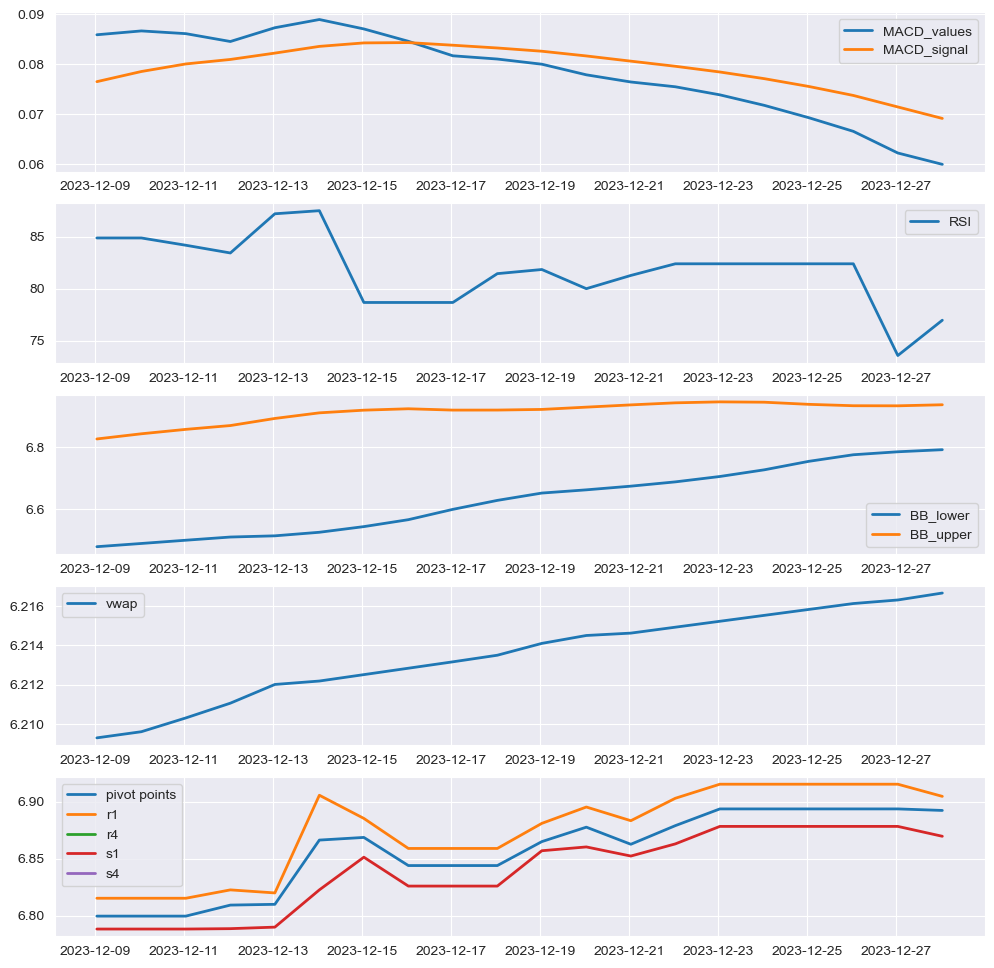

In [117]:
IE_indicators = technical_indicators_factory([funds_w_names['IE00BHZPJ783']], ['IE00BHZPJ783'])

In [118]:
analiza = IE_indicators["IE00BHZPJ783"][["isOversold", "isOverbought", "Bullish", "Bearish", "Return"]]

In [ ]:
import seaborn as sns
corr1 = analiza.corr()
sns.heatmap(corr1, annot=True, cmap="coolwarm", fmt=".2f")

In [119]:
test_funds_indic = defaultdict(pd.DataFrame)
train_funds_indic = defaultdict(pd.DataFrame)
for i in funds_w_names:
    train_funds_indic[i] = funds_w_names[i][:-31]
    test_funds_indic[i] = funds_w_names[i][-31:]

    test_funds_indic[i]["Close"] = 0.0
    test_funds_indic[i].index = pd.to_datetime(test_funds_indic[i].index)

    train_funds_indic[i].index = pd.to_datetime(train_funds_indic[i].index)
    test_funds_indic[i]["time_idx"] = (test_funds_indic[i].index - test_funds_indic[i].index.min()).days
    train_funds_indic[i]["time_idx"] = (train_funds_indic[i].index - train_funds_indic[i].index.min()).days

In [ ]:
IE_indicators_tft, training, val = fit(epochs=120, batch_size=64, df=train_funds_indic["IE00BHZPJ783"], independent_variables=["Open", "High", "Low", "Volume", "isOverbought", "Bullish"],gradient_clip=0.02, drop=0.15, hidden_size=31, hidden_continuous_size=12, attention_head_size=4, learning_rate=0.006, max_prediction_length=31, min_encoder_length=0)

In [ ]:
IE_indicators_preds = predictt(IE_indicators_tft, training, test_funds_indic["IE00BHZPJ783"])

1124
31


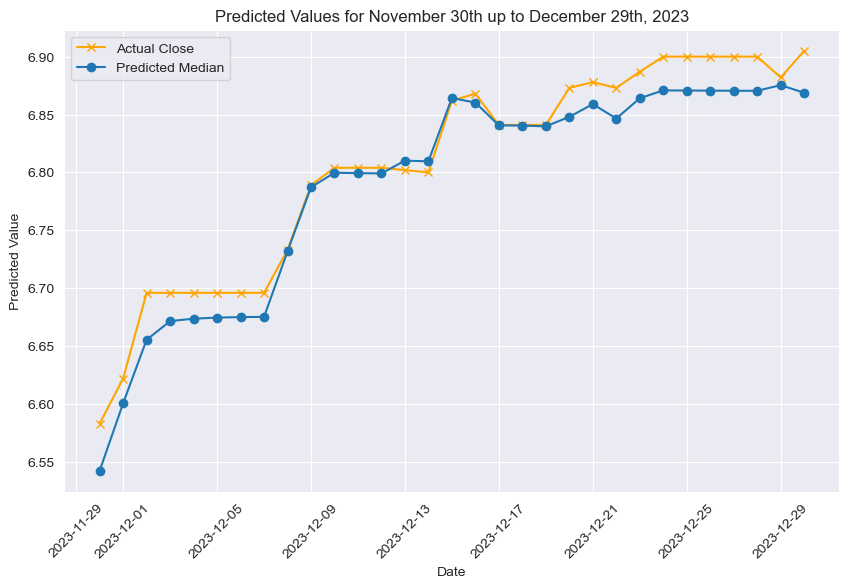

In [125]:
IE_indicators_rse, IE_indicators_rae, IE_indicators_huber= metrics_and_plt(funds_w_names["IE00BHZPJ783"], IE_indicators_preds[-31:], pd.date_range(start="2023-11-30", end="2023-12-30"), date="2023-11-28")

3) ONE FUND, INDICATORS, RESIDUALS

In [69]:
resztki = abs(IE_indicators_preds - IE_indicators["IE00BHZPJ783"]["Close"]["2022-11-30":"2024-01-30"])

In [95]:
df_scary = test_funds_indic["IE00BHZPJ783"].copy()
df_scary["Remainders"] = resztki

In [96]:
df_scary.index = pd.to_datetime(df_scary.index)  # ensure index is datetime if not already
df_scary["time_idx"] = (df_scary.index.date - df_scary.index.date[0]).astype("timedelta64[D]").astype(int)
df_scary['group_id'] = IE_indicators["IE00BHZPJ783"]["group_id"]

In [97]:
df_scary_test = df_scary[-31:]
df_scary_train = df_scary[:-31]

df_scary_test["Remainders"] = 0.0
df_scary_test["Close"] = 0.0
df_scary_test.index = pd.to_datetime(df_scary_test.index)

df_scary_train.index = pd.to_datetime(df_scary_train.index)
df_scary_test["time_idx"] = (df_scary_test.index - df_scary_test.index.min()).days
df_scary_train["time_idx"] = (df_scary_train.index - df_scary_train.index.min()).days

In [93]:
len(df_scary)

427

In [ ]:
IE_tft_res, training_res, val_res = fit(epochs=120, batch_size=4, df=df_scary_train, independent_variables=["Open", "High", "Low", "Volume", "isOverbought", "Bullish"], target="Remainders", max_prediction_length=31, drop=0.14, hidden_size=31, learning_rate=0.006, attention_head_size=4, gradient_clip=0.4, hidden_continuous_size=9, min_encoder_length=0, training_cutoff_idx=342)

In [ ]:
IE_tft_rem_preds= predictt(IE_tft_res, training_res, df_scary_test)

31
31


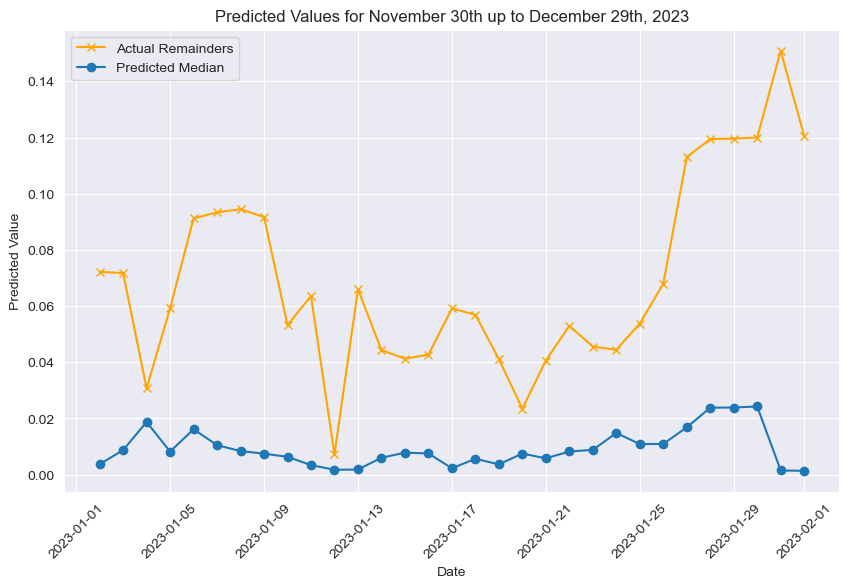

In [107]:
IE_model2_rse, IE_model2_rae, IE_model2_huber= metrics_and_plt(df_scary[-31:], IE_tft_rem_preds, pd.date_range(start="2023-01-02", end="2023-02-01"), target="Remainders", date="2023-01-01")

In [108]:
IE_model2_rse

Decimal('4.154223015000836103056991565')

In [109]:
IE_model2_rae

Decimal('2.194822176321019181054627345')

In [ ]:
IE_model2_huber

In [ ]:
final_preds = IE_indicators_preds.copy()[-31:] + IE_tft_rem_preds

In [ ]:
IE_model2_final_rse, IE_model2_final_rae, IE_model2_final_huber= metrics_and_plt(df_scary[30:], final_preds, pd.date_range(start="2023-11-29", end="2023-12-29"), target="Close", date="2023-11-28")

In [ ]:
print(IE_model2_final_rse)
print(IE_model2_final_rae)
print(IE_model2_final_huber)

4) MANY FUNDS, INDICATORS, PRICE

In [ ]:
funds_for_hedge = ["IE00BFNM3G45", "IE00BHZPJ783", "36BA.DE", "DTLE.L", "UEEF.DE"]

dataframes_funds = []
for fund in funds_for_hedge:
    dataframes_funds.append(funds_w_names[fund])
fund_name_fund_df = technical_indicators_factory(dataframes_funds, funds_for_hedge)

In [127]:
test_funds_indic = defaultdict(pd.DataFrame)
train_funds_indic = defaultdict(pd.DataFrame)
for i in funds_w_names:
    test_funds_indic[i] = funds_w_names[i][-31:]
    train_funds_indic[i] = funds_w_names[i][:-31]
    #test_funds[i]= test_funds[i].drop('Close', axis=1)
    test_funds_indic[i]["Close"] = 0.0
    test_funds_indic[i].index = pd.to_datetime(test_funds_indic[i].index)

    train_funds_indic[i].index = pd.to_datetime(train_funds_indic[i].index)
    test_funds_indic[i]["time_idx"] = (test_funds_indic[i].index - test_funds_indic[i].index.min()).days
    train_funds_indic[i]["time_idx"] = (train_funds_indic[i].index - train_funds_indic[i].index.min()).days

In [128]:
dataframes_funds_test = []
dataframes_funds_train = []
dataframes_funds2 = []
for fund in funds_for_hedge:

    dataframes_funds_test.append(test_funds_indic[fund])
    dataframes_funds_train.append(train_funds_indic[fund])


In [ ]:
results = []
results.append([{'gradient_clip_val': 0.05487592844974305, 'hidden_size': 109, 'dropout': 0.07599425638044498, 'hidden_continuous_size': 67, 'attention_head_size': 6, 'learning_rate': 0.009880128675887067}])
results.append([{'gradient_clip_val': 0.04683258007832345, 'hidden_size': 99, 'dropout': 0.1492414102035759, 'hidden_continuous_size': 98, 'attention_head_size': 2, 'learning_rate': 0.0038489461032895464}])
results.append([{'gradient_clip_val': 0.023089743927082688, 'hidden_size': 78, 'dropout': 0.1013771128449902, 'hidden_continuous_size': 77, 'attention_head_size': 5, 'learning_rate': 0.002925218301298973}])
results.append([{'gradient_clip_val': 0.06277093921861779, 'hidden_size': 72, 'dropout': 0.05910852292926, 'hidden_continuous_size': 65, 'attention_head_size': 7, 'learning_rate': 0.005555285552256754}])
results.append([{'gradient_clip_val': 0.10653386157554227,'hidden_size': 81,'dropout': 0.13826540826415204,'hidden_continuous_size': 81,'attention_head_size': 4,'learning_rate': 0.006689369646581234}])
# optuna(df=dataframes_funds_train[4], batch_size = 64, independent_variables=["Open", "High", "Low", "Volume", "isOverbought", "Bullish"], max_prediction_length =31, min_encoder_length=0, target="Close")

In [ ]:
# best_params_per_model_REMAINDERS = [
#     {'gradient_clip_val': 0.9837710153630486, 'hidden_size': 31, 'dropout': 0.2350576066043487, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.015128183009392497},
#     {'gradient_clip_val': 0.023769508697715387, 'hidden_size': 29, 'dropout': 0.257857631364907, 'hidden_continuous_size': 29, 'attention_head_size': 3, 'learning_rate': 0.010048083399591495},
#     {'gradient_clip_val': 0.3097192385777495, 'hidden_size': 52, 'dropout': 0.12006384860557215, 'hidden_continuous_size': 23, 'attention_head_size': 3, 'learning_rate': 0.0042138867532417945},
#     {'gradient_clip_val': 0.01713316479279881, 'hidden_size': 41, 'dropout': 0.29028753651888917, 'hidden_continuous_size': 22, 'attention_head_size': 2, 'learning_rate': 0.010944731823071836},
#     {'gradient_clip_val': 0.1364092614065398, 'hidden_size': 59, 'dropout': 0.29882754959481694, 'hidden_continuous_size': 45, 'attention_head_size': 4, 'learning_rate': 0.0034770030794033604}]

In [ ]:
# best_params_per_model = [
#     {'gradient_clip_val': 0.1170917991042152, 'hidden_size': 60, 'dropout': 0.11869613309043395,
#      'hidden_continuous_size': 19, 'attention_head_size': 4, 'learning_rate': 0.003814810368668662},
#     {'gradient_clip_val': 0.015691176093369945, 'hidden_size': 98, 'dropout': 0.29590810356280955,
#      'hidden_continuous_size': 37, 'attention_head_size': 6, 'learning_rate': 0.005478633587765633},
#     {'gradient_clip_val': 0.032540265870562794, 'hidden_size': 75, 'dropout': 0.28617284712308855,
#      'hidden_continuous_size': 36, 'attention_head_size': 5, 'learning_rate': 0.005579041886792157},
#     {'gradient_clip_val': 0.27402792475271975, 'hidden_size': 14, 'dropout': 0.16937295209546838,
#      'hidden_continuous_size': 10, 'attention_head_size': 4, 'learning_rate': 0.007985354289781083},
#     {'gradient_clip_val': 0.11871482116616788, 'hidden_size': 62, 'dropout': 0.16547754484324415,
#      'hidden_continuous_size': 34, 'attention_head_size': 2, 'learning_rate': 0.0012659431875886532}
# ]

In [ ]:
transformers=[]
vals=[]
trs=[]
for i, (params, fund) in enumerate(zip(results, dataframes_funds_train)):
    gradient_clip_val = params[0]['gradient_clip_val']
    hidden_size = params[0]['hidden_size']
    dropout = params[0]['dropout']
    hidden_continuous_size = params[0]['hidden_continuous_size']
    attention_head_size = params[0]['attention_head_size']
    learning_rate = params[0]['learning_rate']

    independent_variables = ["Open", "High", "Low", "Volume", "isOverbought", "Bullish"]

    tft, training, val = fit(
        gradient_clip=gradient_clip_val,
        hidden_size=hidden_size,
        drop=dropout,
        hidden_continuous_size=hidden_continuous_size,
        attention_head_size=attention_head_size,
        learning_rate=learning_rate,
        epochs=200,                # Or set it dynamically
        batch_size=64,            # Or set it dynamically
        df=fund,                   # Pass the fund data
        independent_variables=independent_variables,  # Pass independent variables
        min_encoder_length=0,
        max_prediction_length=31,
    )

    transformers.append(tft)
    vals.append(val)
    trs.append(training)

In [ ]:
pred = []
for i in range(len(dataframes_funds_test)):
    pred.append(predictt(transformers[i], trs[i], dataframes_funds_test[i]))

In [ ]:
len(transformers)

1124
31


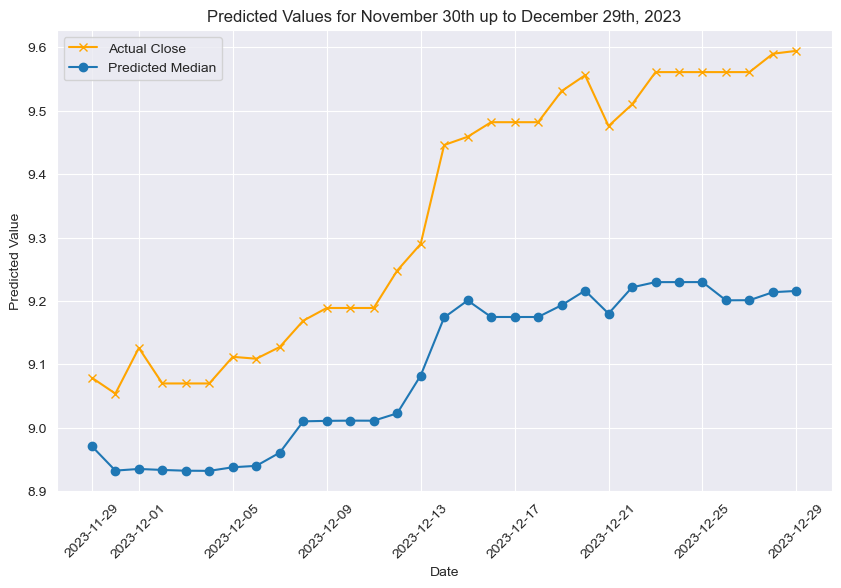

In [144]:
IE_many1_rse0, IE_many1_rae0, IE_many1_hub0= metrics_and_plt(funds_w_names[funds_for_hedge[0]], pred[0][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [154]:
print(IE_many1_rse0)
print(IE_many1_rae0)
print(IE_many1_hub0)

1.677683991302375779084762109
1.278170916310808600418755593
0.034132203445052814


1124
31


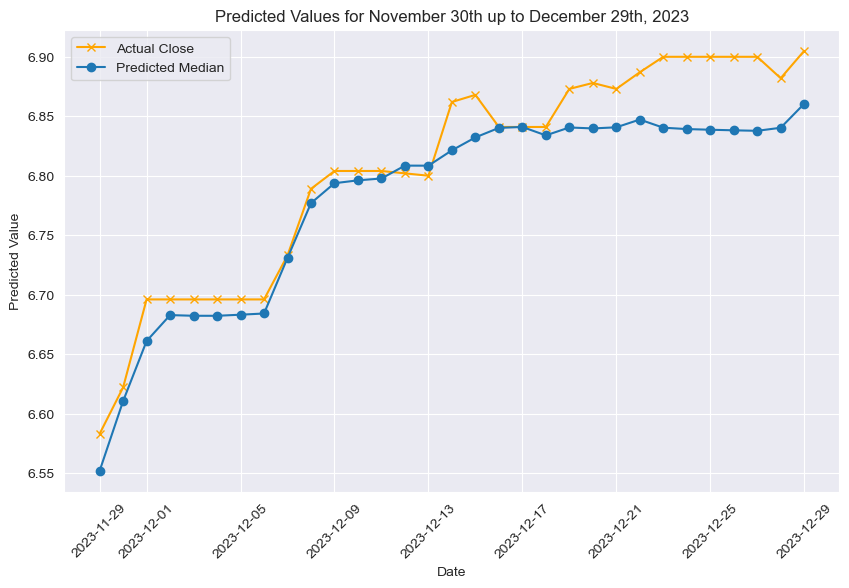

In [146]:
IE_many1_rse1, IE_many1_rae1, IE_many1_hub1= metrics_and_plt(funds_w_names[funds_for_hedge[1]], pred[1][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [155]:
print(IE_many1_rse1)
print(IE_many1_rae1)
print(IE_many1_hub1)

0.1351238364370054470407742632
0.3501450176414405043880494657
0.0005513737980671126


1124
31


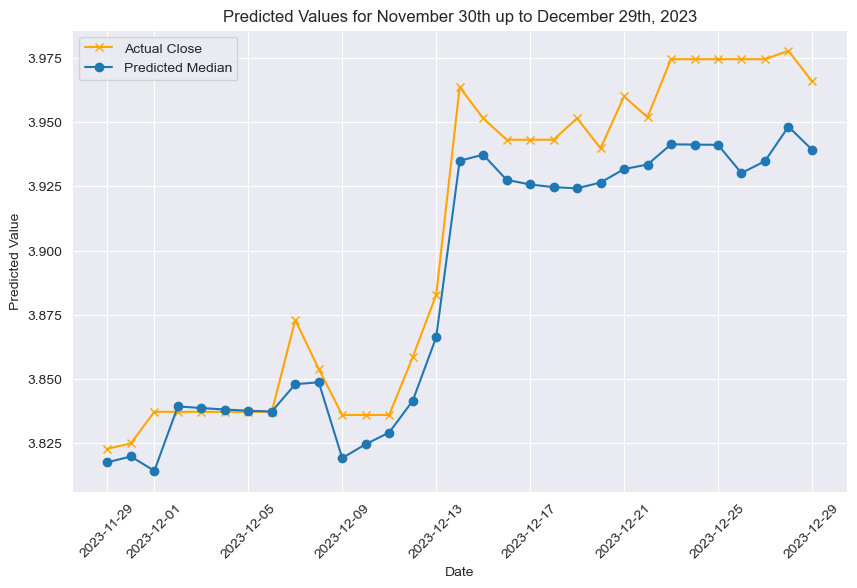

In [148]:
IE_many1_rse2, IE_many1_rae2, IE_many1_hub2= metrics_and_plt(funds_w_names[funds_for_hedge[2]], pred[2][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [156]:
print(IE_many1_rse2)
print(IE_many1_rae2)
print(IE_many1_hub2)

0.1298302819718545404474596976
0.3080039825245633256915105172
0.00023713070892712965


1124
31


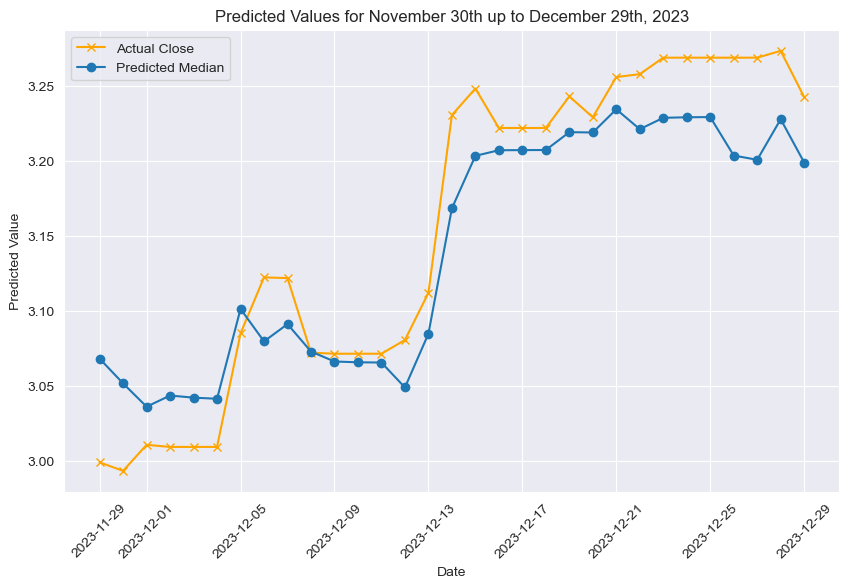

In [150]:
IE_many1_rse3, IE_many1_rae3, IE_many1_hub3= metrics_and_plt(funds_w_names[funds_for_hedge[3]], pred[3][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [157]:
print(IE_many1_rse3)
print(IE_many1_rae3)
print(IE_many1_hub3)

0.1339835071260272683732931242
0.3350282929066333875651366650
0.0007031268311018559


1124
31


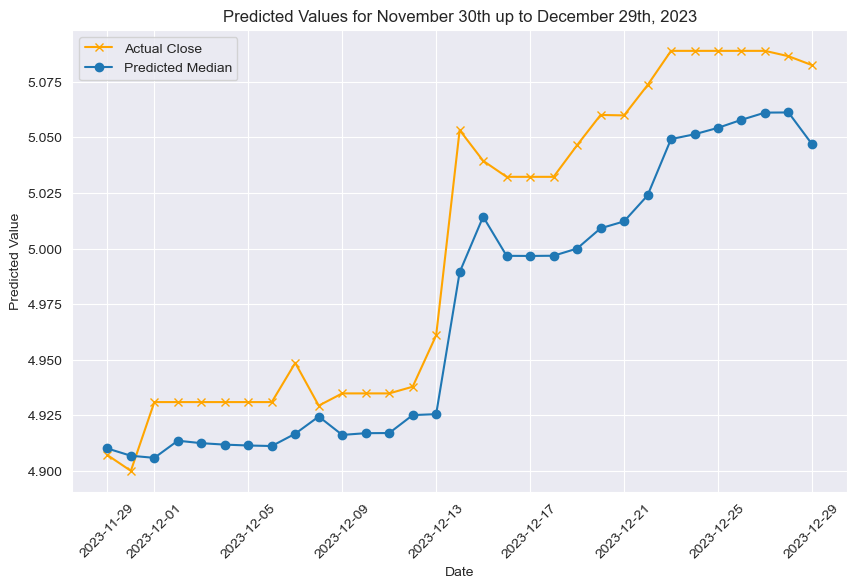

In [152]:
IE_many1_rse4, IE_many1_rae4, IE_many1_hub4= metrics_and_plt(funds_w_names[funds_for_hedge[4]], pred[4][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [158]:
print(IE_many1_rse4)
print(IE_many1_rae4)
print(IE_many1_hub4)

0.2128289980757396298706722994
0.4304546775087480359576825783
0.0005106461883828629


5) MANY FUNDS, INDICATORS, RESIDUALS

In [ ]:
resztkiii = []
for i in range(len(funds_for_hedge)):
    resztkiii.append(abs(pred[i] - fund_name_fund_df[funds_for_hedge[i]]["Close"]["2023-10-28":"2023-12-29"]))

In [ ]:
residualsss=[]
residualsss_test= []
residualsss_train= []
for i in range(len(funds_for_hedge)):
    residualsss.append(funds_w_names[funds_for_hedge[i]][299:].copy())
    residualsss[i]["Remainders"] = resztkiii[i]

#####
    residualsss[i]["Lag1_Remainders"] = residualsss[i]["Remainders"].shift(1)
    residualsss[i]["Lag2_Remainders"] = residualsss[i]["Remainders"].shift(2)
    residualsss[i]["Lag2_Remainders"].bfill(inplace=True)
#####

    residualsss_test.append(residualsss[i][-31:].copy())
    residualsss_train.append(residualsss[i][:-31].copy())
    residualsss_test[i]["Close"] = 0.0
    residualsss_test[i]["Remainders"] = 0.0
    residualsss_test[i].index = pd.to_datetime(residualsss_test[i].index)
    residualsss_train[i].index = pd.to_datetime(residualsss_train[i].index)
    
    residualsss_test[i]["time_idx"] = (residualsss_test[i].index - residualsss_test[i].index.min()).days.astype(int)
    residualsss_train[i]["time_idx"] = (residualsss_train[i].index - residualsss_train[i].index.min()).days.astype(int)

In [ ]:
# results_remainds = []
# for i, f in enumerate(residualsss_train):
#     results_remainds.append(optuna(df=f, batch_size = 128, independent_variables=["Open", "High", "Low", "Volume", "isOverbought", "Bullish", "Lag1_Remainders"], max_prediction_length =30, min_encoder_length=1, target="Remainders"))

In [ ]:
results_remainds = []
results_remainds.append(
[{'gradient_clip_val': 0.016417160666555686,'hidden_size': 141,'dropout': 0.09908602764609492,'hidden_continuous_size': 99,'attention_head_size': 2,'learning_rate': 0.0036140528415928236}])
results_remainds.append(
[{'gradient_clip_val': 0.8157163053307734,'hidden_size': 121,'dropout': 0.11861271601391038,'hidden_continuous_size': 91,'attention_head_size': 7,'learning_rate': 0.0011682986920981782}])
results_remainds.append(
[{'gradient_clip_val': 0.04419468845810623,'hidden_size': 97,'dropout': 0.10752859755020902,'hidden_continuous_size': 92,'attention_head_size': 6,'learning_rate': 0.0019418577054400815}])
results_remainds.append(
[{'gradient_clip_val': 0.054058194696041964,'hidden_size': 112,'dropout': 0.09340608143087316,'hidden_continuous_size': 103,'attention_head_size': 7,'learning_rate': 0.008227561296569047}])
results_remainds.append(
[{'gradient_clip_val': 0.3294856936024062,'hidden_size': 70,'dropout': 0.13404283204997156,'hidden_continuous_size': 65,'attention_head_size': 5,'learning_rate': 0.004266224633904163}])

In [ ]:
transformers_res=[]
vals_res=[]
trs_res=[]
for i, (params, fund) in enumerate(zip(results_remainds, residualsss_train)):
    gradient_clip_val = params[0]['gradient_clip_val']
    hidden_size = params[0]['hidden_size']
    dropout = params[0]['dropout']
    hidden_continuous_size = params[0]['hidden_continuous_size']
    attention_head_size = params[0]['attention_head_size']
    learning_rate = params[0]['learning_rate']

    independent_variables = ["Lag1_Remainders"]

    tft, training, val = fit(
        # drop=0.14, hidden_size=31, learning_rate=0.006, attention_head_size=4, gradient_clip=0.4, hidden_continuous_size=9,
        gradient_clip=gradient_clip_val,
        hidden_size=hidden_size,
        drop=dropout,
        hidden_continuous_size=hidden_continuous_size,
        attention_head_size=attention_head_size,
        learning_rate=learning_rate,
        epochs=1000,                # Or set it dynamically
        batch_size=30,            # Or set it dynamically
        df=fund,                   # Pass the fund data
        independent_variables=independent_variables,  # Pass independent variables
        min_encoder_length=1,
        max_prediction_length=30,
        target="Remainders"
    )

    transformers_res.append(tft)
    vals_res.append(val)
    trs_res.append(training)

In [ ]:
modell = ARIMA(residualsss_train[0]["Remainders"], order=(5, 2, 0))
modell_trial = modell.fit()
arima_yyy = modell_trial.forecast(steps=31)
print("ARIMA Forecast for the next 30 periods:", arima_yyy)

fig, axes = plt.subplots(2, 1, figsize=(12,6))

axes[0].plot(funds_w_names["IE00BFNM3G45"][-31:].index, arima_yyy[-31:], label='arima_forecast', linewidth=2)
axes[0].plot(funds_w_names["IE00BFNM3G45"][-31:].index, residualsss[0]["Remainders"][-31:], label='Remainders', linewidth=2)
axes[0].legend(loc='best')

In [ ]:
residualsss_train[0]

In [ ]:
res_preds_final = []
for i in range(len(funds_for_hedge)):
    res_preds_final.append(predictt(transformers_res[i], trs_res[i], residualsss_test[i]))

In [ ]:
IE_many1_res_rse0, IE_many1_res_rae0, IE_many1_res_hube0 = metrics_and_plt(residualsss[0][-30:], res_preds_final[0],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
IE_many1_res_rse0
IE_many1_res_rae0
IE_many1_res_hube0

In [ ]:
IE_many1_res_rse1, IE_many1_res_rae1, IE_many1_res_huber1= metrics_and_plt(residualsss[1][-30:], res_preds_final[1],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
IE_many1_res_rse1
IE_many1_res_rae1
IE_many1_res_huber1

In [ ]:
IE_many1_res_rse2, IE_many1_res_rae2, IE_many1_res_huber2= metrics_and_plt(residualsss[2][-30:], res_preds_final[2],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
IE_many1_res_rse2
IE_many1_res_rae2
IE_many1_res_huber2

In [ ]:
IE_many1_res_rse3, IE_many1_res_rae3, IE_many1_res_huber3 = metrics_and_plt(residualsss[3][-30:], res_preds_final[3],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
print(IE_many1_res_rse3)
print(IE_many1_res_rae3)
print(IE_many1_res_huber3)

In [ ]:
IE_many1_res_rse4, IE_many1_res_rae4, IE_many1_res_huber4 = metrics_and_plt(residualsss[4][-30:], res_preds_final[4],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
IE_many1_res_rse4
IE_many1_res_rae4
IE_many1_res_huber4

eksperyment do usuniecia acf pacf

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
sm.graphics.tsa.plot_acf(resztkiii[0], lags=30, ax=axes[0])  # ACF plot
sm.graphics.tsa.plot_pacf(resztkiii[0], lags=30, ax=axes[1])  # PACF plot
plt.show()


6) FINAL RESULT PRICE + RESIDUALS

In [ ]:
final_many_preds = []
for i in range(len(funds_for_hedge)):
    final_many_preds.append(pred[i].copy()[-30:] + res_preds_final[i])

In [ ]:
IE_final_many1_res_rse_0, IE_final_many1_res_rae_0, IE_final_many1_res_huber_0 = metrics_and_plt(funds_w_names[funds_for_hedge[0]][-30:], final_many_preds[0],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Close", date="2023-11-28")

In [ ]:
IE_final_many1_res_rse_1, IE_final_many1_res_rae_1, IE_final_many1_res_huber_1 = metrics_and_plt(funds_w_names[funds_for_hedge[1]][-30:], final_many_preds[1],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Close", date="2023-11-28")

In [ ]:
IE_final_many1_res_rse_2, IE_final_many1_res_rae_2, IE_final_many1_res_huber_2 = metrics_and_plt(funds_w_names[funds_for_hedge[2]][-30:], final_many_preds[2],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Close", date="2023-11-28")

In [ ]:
IE_final_many1_res_rse_3, IE_final_many1_res_rae_3, IE_final_many1_res_huber_3 = metrics_and_plt(funds_w_names[funds_for_hedge[3]][-30:], final_many_preds[3],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Close", date="2023-11-28")

In [ ]:
print(IE_final_many1_res_rse_3)
print(IE_final_many1_res_rae_3)
print(IE_final_many1_res_huber_3)

In [ ]:
IE_final_many1_res_rse_4, IE_final_many1_res_rae_4, IE_final_many1_res_huber_4= metrics_and_plt(funds_w_names[funds_for_hedge[4]][-30:], final_many_preds[4],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Close", date="2023-11-28")

MONTE CARLO PREDICTING RISK

In [ ]:
def calc_drift(fund):
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    avg_pdr = log_returns.mean()
    var = log_returns.var()
    drift = avg_pdr-(.5*var)

    return drift

In [ ]:
def monte_carlo_sim(fund):
    drift = calc_drift(fund)
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    stdev=log_returns.std()
    days=1124
    trials=100
    Z = norm.ppf(np.random.rand(days,trials))
    daily_returns=np.exp(np.array(drift) + np.array(stdev) * Z)
    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = fund["Close"].iloc[-1]
    for i in range(1,days):
        price_paths[i] = price_paths[i-1] * daily_returns[i]
    return price_paths

In [199]:
drifts = calc_drift(funds_w_names["DTLE.L"])
pp = monte_carlo_sim(funds_w_names["DTLE.L"])

In [200]:
def volatility_mc(price_paths: pd.DataFrame):
    pp_df = pd.DataFrame(price_paths)
    pp_df= pp_df.pct_change()
    pp_df.fillna(value=0, inplace=True)
    pp_df=pp_df.rolling(7).std()
    pp_df.fillna(method="bfill", inplace=True)
    return pp_df.mean(axis=1)

In [312]:
simv = volatility_mc(pp)

In [317]:
simv = np.array(simv)

monte carlo metrics

In [356]:
m = mean_squared_error(funds_w_names["DTLE.L"]["Rolling Volatility"], simv)
print(f"MSE: {m}")

MSE: 1.0553377690147275e-05


In [359]:
sample_variance = np.var(simv, ddof=1)
print(f"Sample Variance: {sample_variance}")

Sample Variance: 5.411969819337608e-08


In [360]:
n = len(simv)
half_n = n // 2

std_n = np.std(simv)
std_half_n = np.std(simv[:half_n])

convergence_factor = std_half_n / std_n
print(f"Convergence Factor: {convergence_factor}")

Convergence Factor: 0.9924285138444467


In [342]:
simv

array([0.00750289, 0.00750289, 0.00750289, ..., 0.00808004, 0.00815692,
       0.00827868])

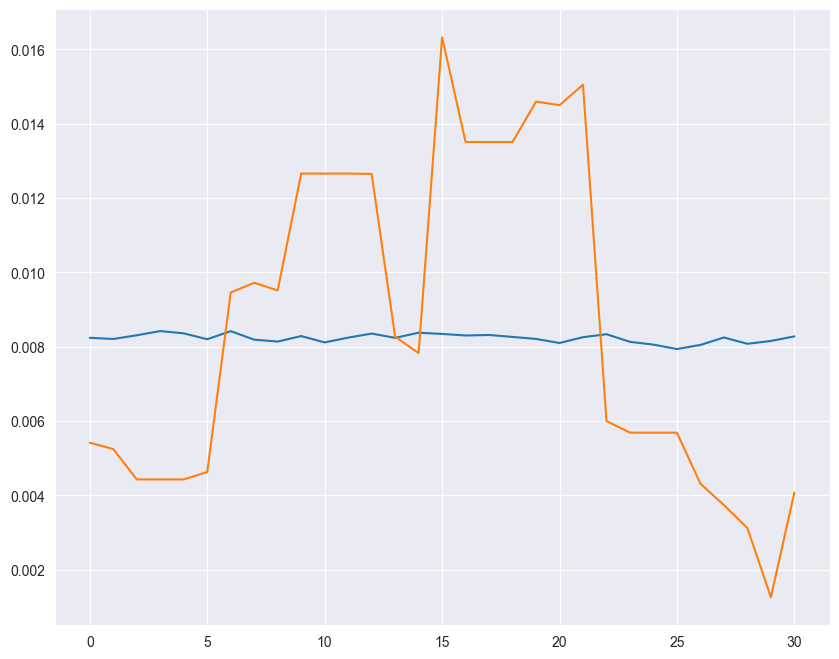

In [347]:
plt.figure(figsize=(10, 8))
plt.plot(simv[-31:])
plt.plot(range(0,31),funds_w_names["DTLE.L"]["Rolling Volatility"][-31:])

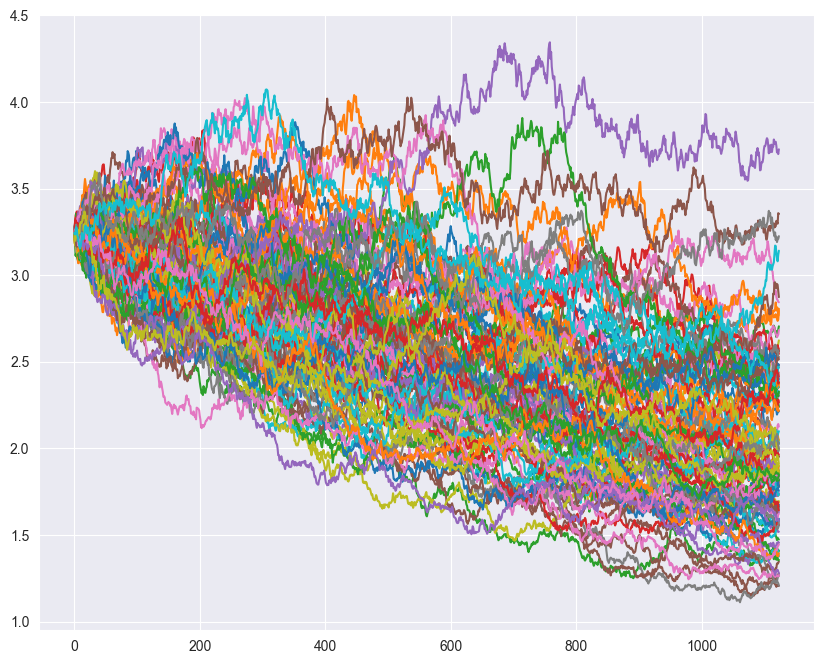

In [341]:
plt.figure(figsize=(10, 8))
plt.plot(pp)

Volatility tft

In [ ]:
IE_vol_tft, training, val = fit(epochs=150, batch_size=64, df=train_funds_indic["DTLE.L"],
                                       independent_variables=["Open", "High", "Low", "Volume", "isOverbought",
                                                              "Bullish"], gradient_clip=0.02, drop=0.15, hidden_size=31,
                                       hidden_continuous_size=12, attention_head_size=4, learning_rate=0.006,
                                       max_prediction_length=62, min_encoder_length=0, target="Rolling Volatility")

In [ ]:
DTLE = test_funds_indic["DTLE.L"].copy()

In [ ]:
IE_vol_preds = predictt(IE_vol_tft, training, DTLE)

In [ ]:
IE_vol_rse, IE_vol_rae, IE_vol_huber= metrics_and_plt(
    funds_w_names["DTLE.L"], IE_vol_preds[-30:], pd.date_range(start="2023-11-30", end="2023-12-29"),
    date="2023-11-29", target="Rolling Volatility")

In [ ]:
mean_squared_error(funds_w_names["DTLE.L"]["Rolling Volatility"][-62:], IE_vol_preds)

In [ ]:
sample_variance = np.var(simv, ddof=1)
print(f"Sample Variance: {sample_variance}")

In [ ]:

n = len(simv)
half_n = n // 2

std_n = np.std(simv)
std_half_n = np.std(simv[:half_n])

convergence_factor = std_half_n / std_n
print(f"Convergence Factor: {convergence_factor}")

TEZ DO KOSZA

In [ ]:
# list_of_5_df_funds = []

In [ ]:
# def nearest_positive_definite(matrix):
#     P = matrix.copy()
#     eigvals, eigvecs = np.linalg.eigh(P)
#     eigvals[eigvals < 0] = 1e-10
#     return eigvecs @ np.diag(eigvals) @ eigvecs.T

In [ ]:
# variances = {}
# covs_means = []
# for k,v in funds_w_names.items():
#     variances[k] = v["Rolling Volatility"]
# variances = pd.DataFrame(variances)
# r = variances.pct_change()
# covariance_matrix = r.cov()
# mean_returns = r.mean()

In [ ]:
# if not np.all(np.linalg.eigvals(covariance_matrix) > 0):
#     print("Covariance matrix not positive definite. Adding regularization.")
#     covariance_matrix = nearest_positive_definite(covariance_matrix)

In [ ]:
# #to be filled with real data
# portfolio_weights = np.random.random(len(mean_returns)) # distribution of etfs in portfolio
# portfolio_weights /= np.sum(portfolio_weights)

In [ ]:
# initial_portfoloio = 0
# for i, v in enumerate(funds_w_names.values()):
#     initial_portfoloio += portfolio_weights[i] * v["Close"][i]

In [ ]:
# days = 60
# simulations = 100
# portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0) # default
# mean_matrix = np.full(shape=(days, len(portfolio_weights)), fill_value=mean_returns).T # days x all etfs

In [ ]:
# for s in range(0, simulations):
#     Z = np.random.normal(size=(days, len(portfolio_weights)))
#     L = np.linalg.cholesky(covariance_matrix)
#     daily_returns = mean_matrix + np.inner(L, Z)
#     portfolio_sims[:, s] = np.cumprod(np.inner(portfolio_weights, daily_returns.T)+1)*initial_portfoloio
#
# plt.plot(portfolio_sims)
# plt.ylabel("Portfolio Simulations")

expected volatility

In [ ]:
# portfolio_returns = portfolio_sims[-1] / portfolio_sims[0] - 1  # final value over initial value gives portfolio returns
# portfolio_volatility = np.std(portfolio_returns)
# print(f"Portfolio Volatility: {portfolio_volatility:.4f}")

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(portfolio_sims)
# plt.title("Monte Carlo Simulations of Portfolio Value")
# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.show()

expected return

In [ ]:
# discounted_prices = [sim[-1]*0.96 for sim in portfolio_sims]

In [ ]:
# avg = np.average(discounted_prices)

MONTE CARLO EVALUATION FUNCITON

In [ ]:
# def test_robustness(paths, num_trials, tol=0.01):
#     means = []
#     for i in range(num_trials):
#         np.random.seed(i)
#         new_paths = np.random.choice(paths, size=len(paths), replace=True)
#         means.append(np.mean(new_paths))
#     glob_mean = np.mean(means)
#     devs = np.abs(np.array(means) - glob_mean)
#     return max(0, 1 - (np.mean(devs) / (tol*glob_mean)))

In [ ]:
# def compute_convergence_rate(paths, true_val):
#     cum_means = np.cumsum(paths)/np.arange(1, len(paths)+1)
#     difs = np.abs(cum_means - true_val)
#     final = difs[-1]
#     avg = np.mean(difs)
#     if avg == 0.0:
#         return 1.0
#     return max(0, 1-(final/avg))

In [ ]:
# def rate_mc_simulation(paths, true_value, runtime, weights):
#     mean_estimate = np.mean(paths)
#     variance = np.var(paths)
#     bias = mean_estimate - np.mean(true_value)
#     mse = bias**2 + variance
#     efficiency = 1 / (runtime * mse)
#
#     robustness = test_robustness(paths.mean(axis=1), 150)
#
#     convergence_rate = compute_convergence_rate(paths.mean(axis=1), true_value)
#
#     score = (
#             weights[0] * convergence_rate +
#             weights[1] * (1 / np.std(paths)) +
#             weights[2] * (1 / abs(bias)) +
#             weights[3] * (1 / variance) +
#             weights[4] * efficiency +
#             weights[5] * robustness)
#     return score

In [ ]:
# weights=[1/6,1/6,1/6,1/6,1/6,1/6]
# pd.Series(pp['DTLE.L'].mean(axis=1))

REDESIGN PORTFOLIO

In [ ]:
# '''
# list of predictions for each fund in portfolio
# '''
# final_many_preds

In [ ]:
# '''
# calculate ratio of a single fund based on provided predictions
# '''
# def calculate_funds_ratio(funds_preds, fund: pd.DataFrame):
#     funds_return = fund["Close"].iloc[-62] - funds_preds[-1]
#     funds_risk = np.mean(volatility_mc(monte_carlo_sim(fund)))
#     data = yf.Ticker("^TNX").history(period="1d")
#     risk_free_rate = data['Close'].iloc[-1] / 100
#     sharpe_ratio = (funds_return - risk_free_rate) / funds_risk
#     return sharpe_ratio, funds_return

In [ ]:
# def redistribute_funds(funds_dfs:list, weights: list):
#     """
#     for a given portfolio, calculate risk and return for next month for each asset and decide whether to buy more of it
#     funds_dfs is a list of funds dataframes based on portfolio
#     weights is a list of weights for each funds
#     """
# 
#     def objective(w):
#         portfolio_score = sum(
#             w[i] * calculate_funds_ratio(final_many_preds[i], funds_w_names[funds_dfs[i]])[0]
#             for i in range(len(funds_dfs))
#         )
#         return -portfolio_score
# 
#     constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
#     bounds = [(0,1)] * len(funds_dfs)
#     result = minimize(objective, weights, method='CG', bounds=bounds, constraints=constraints)
#     optimized_weights = result.x
#     optimized_score = result.fun
# 
#     returns = [calculate_funds_ratio(final_many_preds[i], funds_w_names[funds_dfs[i]])[1] for i in range(len(funds_for_hedge))]
#     final_gain = np.dot(optimized_weights,returns)
# 
#     return optimized_weights, optimized_score, final_gain

In [ ]:
# better_weights, better_score, final_gain = redistribute_funds(funds_for_hedge, [0.4,0.1,0.1,0.1,0.3])
# print(f"Final Gain: {final_gain}\nBetter Score: {better_score}\nBetter Weights: {better_weights}\n")

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf

def calculate_expected_returns_and_mc_risk(funds_dfs, funds_preds):

    expected_returns = []
    mc_risks = []

    for i, fund in enumerate(funds_dfs):

        last_close = funds_w_names[fund]['Close'].iloc[-62]
        predicted_close = funds_preds[i][-1]
        predicted_return = (predicted_close - last_close) / last_close
        expected_returns.append(predicted_return)

        mc_volatility = np.mean(volatility_mc(monte_carlo_sim(funds_w_names[fund])))
        mc_risks.append(mc_volatility)


    expected_returns = np.array(expected_returns)
    mc_risks = np.array(mc_risks)


    return expected_returns, mc_risks

def objective(weights, expected_returns, mc_risks, lambda_risk_aversion):

    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.dot(weights, mc_risks)


    return lambda_risk_aversion * portfolio_risk - (1 - lambda_risk_aversion) * portfolio_return

def redistribute_funds_mc(funds_dfs, funds_preds, weights, lambda_risk_aversion=0.5):

    expected_returns, mc_risks = calculate_expected_returns_and_mc_risk(funds_dfs, funds_preds)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0.1, 0.9)] * len(funds_dfs)


    result = minimize(objective, weights, args=(expected_returns, mc_risks, lambda_risk_aversion),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed:", result.message)

    optimized_weights = result.x
    optimized_score = -result.fun


    final_return = np.dot(optimized_weights, expected_returns)
    final_risk = np.dot(optimized_weights, mc_risks)


    return optimized_weights, optimized_score, final_return, final_risk

In [ ]:
lambda_risk_aversion = 0.22
better_weights, better_score, final_return, final_risk = redistribute_funds_mc(
    funds_for_hedge,
    final_many_preds,
    [0.4, 0.1, 0.1, 0.1, 0.3],
    lambda_risk_aversion
)

print(f"Final Return: {final_return}\nFinal Risk: {final_risk}\nBetter Weights: {better_weights}\n")